# 🦠 COVID-19 Detection from Chest X-Rays using DenseNet121

## Introduction
The goal of this notebook is to build a Deep Learning model capable of classifying Chest X-Ray images into three categories:
1. **Covid-19**
2. **Viral Pneumonia**
3. **Normal**

## Approach
We will use **Transfer Learning** with the **DenseNet121** architecture. 
* **Why DenseNet121?** It is highly effective for medical imaging due to its feature reuse capability, which preserves low-level textural details essential for detecting lung opacity.
* **Strategy:** We will use a two-stage training process:
    1.  **Warm-up:** Training only the classification head while the base is frozen.
    2.  **Fine-tuning:** Unfreezing the base model and training with a very low learning rate.

## Dataset
* Source: [Covid-19 Image Dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset)
* Structure: Separated into Train and Test folders.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Configuration to hide minor warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2026-02-11 08:28:57.420967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770798537.607148      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770798537.657786      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770798538.092703      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770798538.092737      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770798538.092739      24 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
GPU Available: True


## Data Preprocessing
We define the paths and set up **Data Augmentation** to prevent overfitting. Since medical images are sensitive to orientation, we apply only mild rotations and shifts.

In [2]:
# Dataset Paths
TRAIN_DIR = '/kaggle/input/covid19-image-dataset/Covid19-dataset/train'
TEST_DIR = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test'

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # Slight rotation
    width_shift_range=0.1,   # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,          # Slight zoom
    horizontal_flip=True,    # Mirroring
    fill_mode='nearest'
)

# Test Data (Only Rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Class Indices: {train_generator.class_indices}")

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Class Indices: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


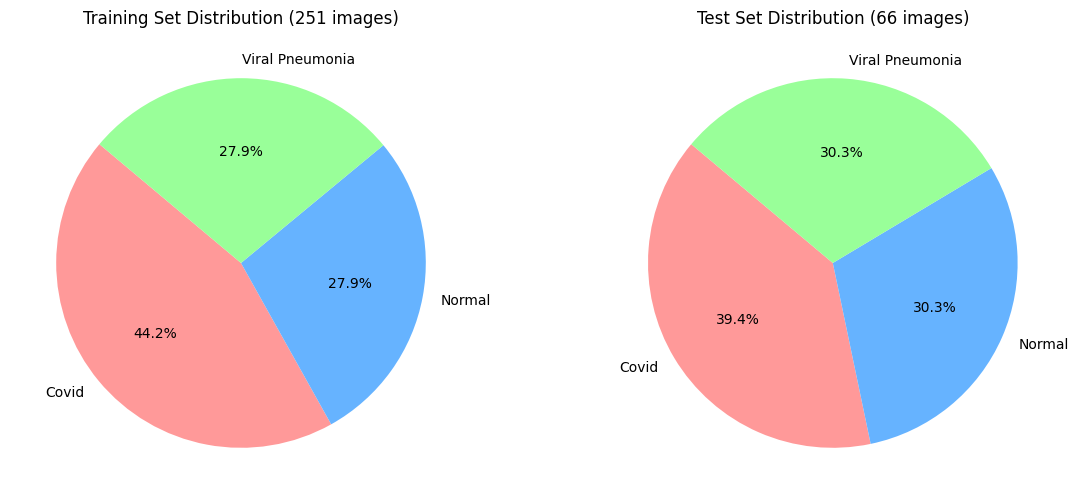

In [3]:
import matplotlib.pyplot as plt

# Get class names and counts
classes = list(train_generator.class_indices.keys())
train_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]
test_counts = [len(os.listdir(os.path.join(TEST_DIR, cls))) for cls in classes]

# Plotting
plt.figure(figsize=(14, 6))

# Training Set Pie Chart
plt.subplot(1, 2, 1)
plt.pie(train_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title(f'Training Set Distribution ({sum(train_counts)} images)')

# Test Set Pie Chart
plt.subplot(1, 2, 2)
plt.pie(test_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title(f'Test Set Distribution ({sum(test_counts)} images)')

plt.show()

#### Let's visualize a batch of images to understand what the model will be looking at.

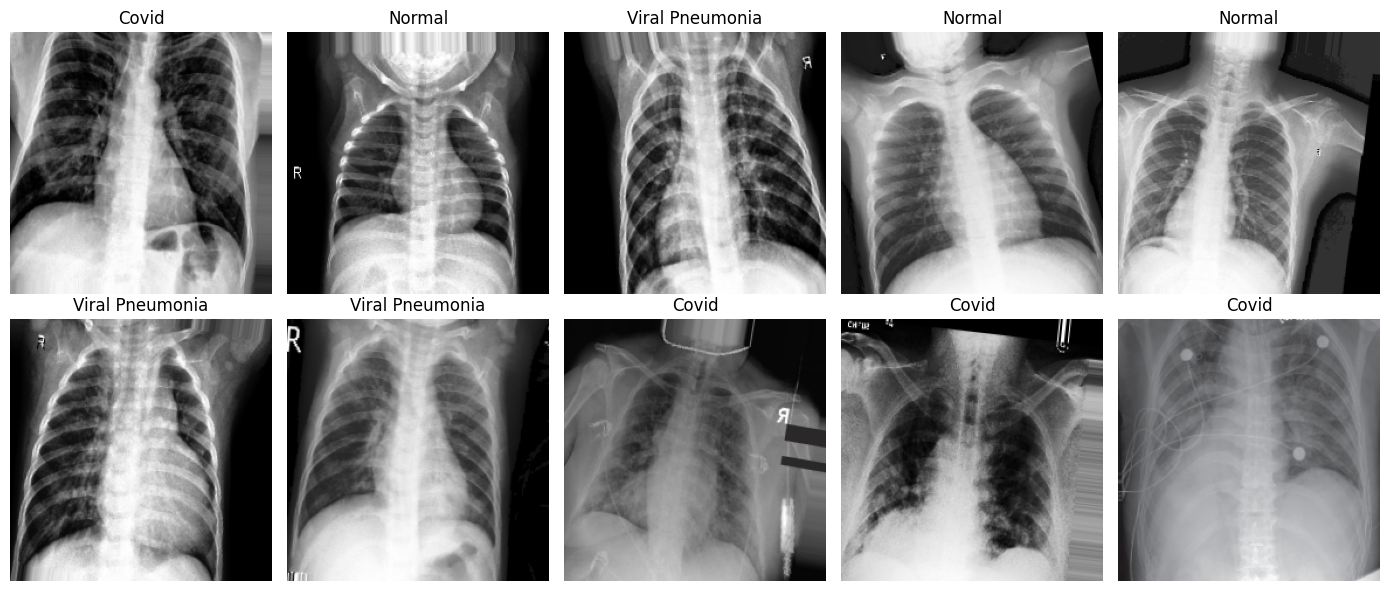

In [4]:
def plot_samples(generator):
    images, labels = next(generator)
    class_dict = {v: k for k, v in generator.class_indices.items()}
    
    plt.figure(figsize=(14, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_dict[label_index])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_generator)

## Model Architecture: DenseNet121
We load the **DenseNet121** model pre-trained on ImageNet.
1.  **Base Model:** Frozen initially (non-trainable).
2.  **Custom Head:** Added `GlobalAveragePooling`, `BatchNormalization`, `Dropout` (0.5), and a `Dense` output layer with Softmax activation.

In [5]:
def build_model():
    # Load Pretrained DenseNet121
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze the base model initially
    base_model.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_model()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=True, 
    expand_nested=True, 
    dpi=60, 
    to_file='model_architecture.png'
)
print("Model architecture saved as 'model_architecture.png'")

I0000 00:00:1770798552.611482      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770798552.617311      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,044,675 (26.87 MB)

 Trainable params: 5,123 (20.01 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

Model architecture saved as 'model_architecture.png'


## Training Stage 1: Frozen Base
We train only the top layers for a few epochs to initialize the weights properly. This prevents large gradient updates from destroying the pre-trained weights in the base model.

In [6]:
# Callbacks
callbacks_stage1 = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

print("--- Starting Stage 1: Training Head Only ---")
history_stage1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks_stage1
)

--- Starting Stage 1: Training Head Only ---
Epoch 1/10


I0000 00:00:1770798572.420184      84 service.cc:152] XLA service 0x7fc6ac01fd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770798572.420229      84 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770798572.420235      84 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770798575.665437      84 cuda_dnn.cc:529] Loaded cuDNN version 91002


1/8 ━━━━━━━━━━━━━━━━━━━━ 3:09 27s/step - accuracy: 0.3125 - loss: 1.6105

I0000 00:00:1770798587.322030      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.4229 - loss: 1.3282 - val_accuracy: 0.4091 - val_loss: 1.1436
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 940ms/step - accuracy: 0.5932 - loss: 0.8819 - val_accuracy: 0.3939 - val_loss: 1.1239
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 911ms/step - accuracy: 0.7491 - loss: 0.5735 - val_accuracy: 0.4697 - val_loss: 1.1068
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 928ms/step - accuracy: 0.8136 - loss: 0.4549 - val_accuracy: 0.4697 - val_loss: 1.0543
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 930ms/step - accuracy: 0.8448 - loss: 0.4316 - val_accuracy: 0.5152 - val_loss: 0.9623
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 934ms/step - accuracy: 0.8283 - loss: 0.4182 - val_accuracy: 0.5152 - val_loss: 0.8850
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 948ms/step - accuracy: 0.8141 - loss: 0.4092 - val_accuracy: 0.5455 - val_loss: 0.8337
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 962ms/step - accuracy: 0.8183 - loss: 0.4112 - val_accuracy: 0.6364 - val_loss: 0.7501
Epoch

## Training Stage 2: Fine-Tuning with Partial Unfreezing (The Secret Sauce 🌶️)

Instead of unfreezing the entire model (which can lead to overfitting on small datasets), we employ a **Partial Unfreezing** strategy.

* **Strategy:** We unfreeze only the **last 50 layers** of the DenseNet121 base.
* **Reasoning:** The initial layers of the network have learned universal features (edges, curves, gradients) from ImageNet that are useful for any image task. The deeper layers, however, hold the high-level logic and pattern recognition. By retraining only these deep layers with a very low learning rate (`1e-5`), we adapt the model to specific lung textures without destroying the foundational features.

In [7]:
print("--- Starting Stage 2: Fine-Tuning ---")

# Unfreeze the base model
base_model.trainable = False

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for fine-tuning
callbacks_stage2 = [
    EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('covid_model_best.keras', save_best_only=True, monitor='val_accuracy')
]

history_stage2 = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    callbacks=callbacks_stage2
)

--- Starting Stage 2: Fine-Tuning ---
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.8832 - loss: 0.3197 - val_accuracy: 0.7576 - val_loss: 0.5792 - learning_rate: 1.0000e-05
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step - accuracy: 0.8953 - loss: 0.2786 - val_accuracy: 0.7576 - val_loss: 0.5556 - learning_rate: 1.0000e-05
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - accuracy: 0.8906 - loss: 0.3242 - val_accuracy: 0.7576 - val_loss: 0.5333 - learning_rate: 1.0000e-05
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9030 - loss: 0.2907 - val_accuracy: 0.7879 - val_loss: 0.5125 - learning_rate: 1.0000e-05
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 933ms/step - accuracy: 0.9127 - loss: 0.2756 - val_accuracy: 0.7879 - val_loss: 0.4931 - learning_rate: 1.0000e-05
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 910ms/step - accuracy: 0.8694 - loss: 0.3314 - val_accuracy: 0.7879 - val_loss: 0.4762 - learning_rate: 1.0000e-05
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 956m

## Performance Evaluation
We evaluate the model using Accuracy/Loss curves and a Confusion Matrix to see specific class performance.

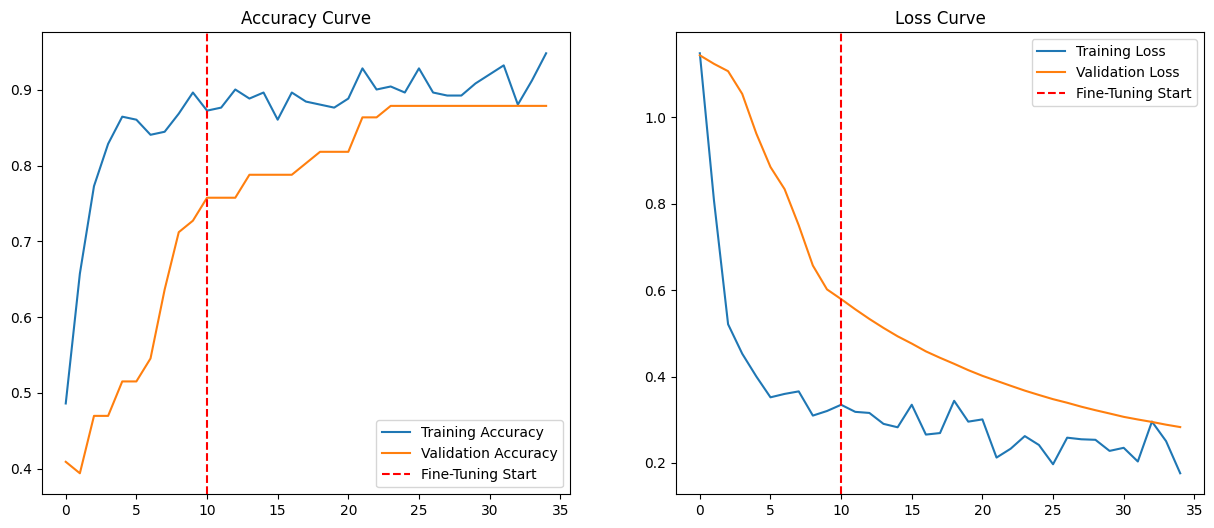

In [8]:
# Merge histories
acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
loss = history_stage1.history['loss'] + history_stage2.history['loss']
val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']

# Plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=len(history_stage1.history['accuracy']), color='r', linestyle='--', label='Fine-Tuning Start')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(history_stage1.history['loss']), color='r', linestyle='--', label='Fine-Tuning Start')
plt.title('Loss Curve')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


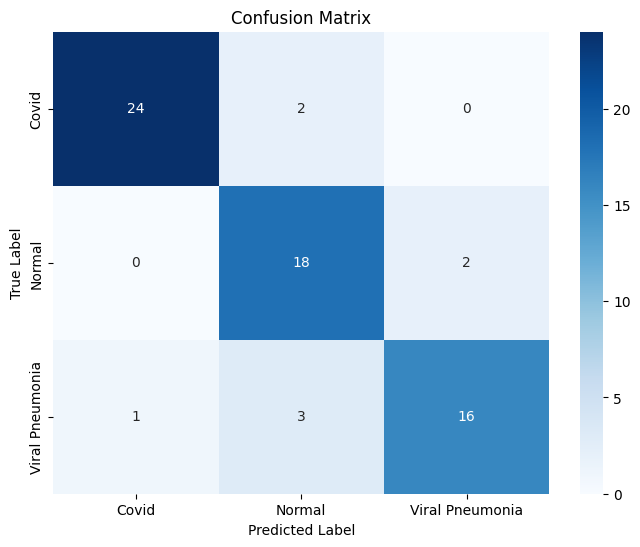

                 precision    recall  f1-score   support

          Covid       0.96      0.92      0.94        26
         Normal       0.78      0.90      0.84        20
Viral Pneumonia       0.89      0.80      0.84        20

       accuracy                           0.88        66
      macro avg       0.88      0.87      0.87        66
   weighted avg       0.88      0.88      0.88        66



In [9]:
# Generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(test_generator.classes, y_pred, 
                            target_names=list(test_generator.class_indices.keys())))

## Real-world Inference
Let's select a random image from the test set and see how the model classifies it.

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


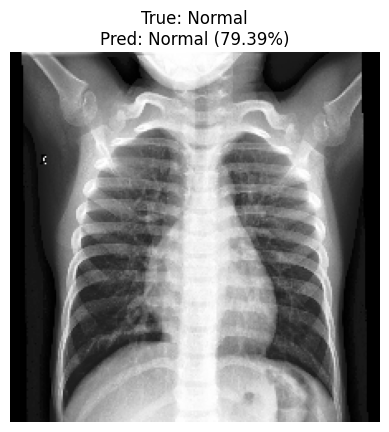

In [10]:
from tensorflow.keras.preprocessing import image
import random

def predict_random_image(model, test_dir):
    # Select random class and image
    classes = list(train_generator.class_indices.keys())
    random_class = random.choice(classes)
    class_path = os.path.join(test_dir, random_class)
    random_image = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_image)
    
    # Preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Predict
    prediction = model.predict(img_array)
    pred_class_idx = np.argmax(prediction)
    pred_class = classes[pred_class_idx]
    confidence = np.max(prediction) * 100
    
    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {random_class}\nPred: {pred_class} ({confidence:.2f}%)")
    plt.show()

predict_random_image(model, TEST_DIR)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


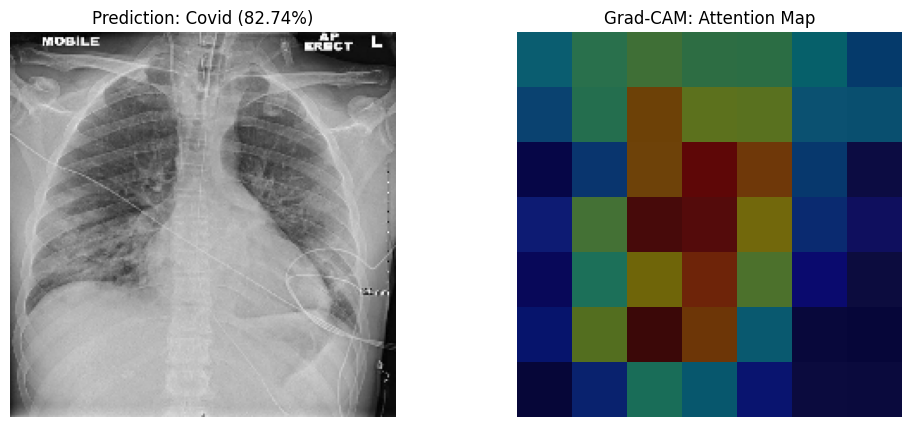

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(model, img_path, last_conv_layer_name='conv5_block16_2_conv'):
    # Prepare image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Get Prediction
    preds = model.predict(img_array)
    pred_index = np.argmax(preds[0])
    class_name = list(train_generator.class_indices.keys())[pred_index]
    confidence = np.max(preds) * 100

    # Generate Heatmap
    # Note: 'conv5_block16_2_conv' is usually the last conv layer in DenseNet121
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)
    except ValueError:
        print(f"Error: Layer {last_conv_layer_name} not found. Check model.summary() for the correct name.")
        return

    # Visualization
    plt.figure(figsize=(12, 5))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {class_name} ({confidence:.2f}%)")
    plt.axis('off')

    # Grad-CAM Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4) # Overlay heatmap
    plt.title("Grad-CAM: Attention Map")
    plt.axis('off')
    plt.show()

# --- RUN THE TEST ---
# Select a random Covid image from the test set
covid_dir = os.path.join(TEST_DIR, 'Covid')
rand_img = os.path.join(covid_dir, random.choice(os.listdir(covid_dir)))

# Execute Grad-CAM
display_gradcam(model, rand_img, last_conv_layer_name='conv5_block16_2_conv')